## Module Imports

In [1]:
import os

import pandas as pd
import numpy as np
import timeit

import matplotlib.pyplot as plt
import seaborn as sns

# Linear model for PCA
from sklearn.linear_model import LogisticRegression

# Estimation maximization
from sklearn.mixture import GaussianMixture

# Neural Network
from sklearn.neural_network import MLPClassifier

# Clustering Algo
from sklearn.cluster import KMeans

# Principal and indipendent component analysis
from sklearn.decomposition import FastICA, PCA

# Randomized projections
from sklearn.random_projection import GaussianRandomProjection,\
      SparseRandomProjection as RCA

# Manifolds
from sklearn.manifold import LocallyLinearEmbedding

# Mertrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score as s_score,\
      calinski_harabasz_score as ch_score,\
        homogeneity_completeness_v_measure as hcv_score, adjusted_rand_score as ar_score,\
        pairwise_distances
from sklearn.metrics import \
    balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline

# pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import \
    LearningCurveDisplay, validation_curve, learning_curve, train_test_split, ShuffleSplit,\
          GridSearchCV, cross_validate

## Data Processing

In [2]:
red_wine = os.path.join('data','wine', 'winequality-red.csv')
white_wine = os.path.join('data','wine', 'winequality-white.csv')
turbine = os.path.join('data','turbine','gt_2011.csv')
mushrooms = os.path.join('data','mushroom','secondary_data.csv')

# encoders to use
scale = StandardScaler()
s_split = ShuffleSplit()
ohe = OneHotEncoder(sparse_output=False)

## SHROOM DATA

In [3]:
transformer = make_column_transformer(
    (
        ohe, 
        [
        'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color',
        'has-ring', 'ring-type', 'spore-print-color','habitat', 'season'
        ]
        ),
    remainder='passthrough'
    )

# pre-process shroom data

shroom_df = pd.read_csv(mushrooms,sep=';').sample(frac=1).reset_index(drop=True)
x = shroom_df.iloc[:,1:].copy()
x_shroom = pd.DataFrame(transformer.fit_transform(x), 
                columns=transformer.get_feature_names_out())
y = shroom_df.iloc[:,0].copy()
y_shroom = (y == 'p')


# reduce the number of training examples
x_shroom = x_shroom[:7000]
y_shroom =  y_shroom[:7000]

# Scale numerical attributes to be b/w 1 and -1
lst_of_num_cols = [
    'remainder__cap-diameter', 'remainder__stem-height', 'remainder__stem-width'
    ]
x_shroom[lst_of_num_cols] = scale.fit_transform(x_shroom[lst_of_num_cols])

## WINE DATA

In [4]:
white_df = pd.read_csv(white_wine, sep=';')
red_df = pd.read_csv(red_wine, sep=';')
white_df['type'] = 0
red_df['type'] = 1
wine_df = pd.concat([white_df,red_df])
wine_df = wine_df.sample(frac=1).reset_index(drop=True)

# set x and y values
# remove 'quality' and 'type' column from x array
x_wine = wine_df.iloc[:,:-2].copy()
# scale x vals
x_wine.values[:,:] = scale.fit_transform(x_wine)
# set y array equal to 'type' column 
y_wine = wine_df.iloc[:,-1].copy()

## Shroom and Wine Train/Test Split

In [5]:
x_shroom_train, x_shroom_test, y_shroom_train, y_shroom_test =\
      train_test_split(x_shroom, y_shroom, test_size=0.2)

x_wine_train, x_wine_test, y_wine_train, y_wine_test =\
      train_test_split(x_wine, y_wine, test_size=0.2)


## Helper Functions

In [6]:
def generate_validation_curve(model, param_grid, x_data, y_data,
                          x_range, param_name, model_name, axs,\
                          plot_train=True, plot_test=True):
    
    train_score, test_score = validation_curve(model, x_data, y_data, 
                                 fit_params=param_grid, scoring='f1_score')
    
    train_mean = train_score.mean(1)
    train_sd = train_score.std(1)
    test_mean = test_score.mean(1)
    test_sd = test_score.std(1)
    axs = axs
    x = x_range
    if plot_train:
        line, = axs.plot(x,train_mean, 'o-')
        axs.fill_between(x,train_mean + train_sd, train_mean - train_sd,alpha=0.3)
    if plot_test:
        axs.plot(x,test_mean,'o-')
        axs.fill_between(x, test_mean + test_sd, test_mean - test_sd,alpha=0.3)
    axs.set_title(f'{model_name} validation curve', fontsize = 15)
    axs.set_xlabel(f'{param_name}', fontsize = 15)
    axs.set_ylabel(f'f1 score', fontsize = 15)
    axs.legend()
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.tick_params(axis='both', which='minor', labelsize=15)

    return line

In [7]:
def generate_learning_curve(model, param_grid, x_data, y_data,
                          x_range, param_name, model_name, axes,\
                          plot_train=True, plot_test=True):
    
    train_sizes, train_scores, test_scores, fit_times, score_times =\
          learning_curve(model, x_data, y_data,)

    train_mean = train_scores.mean(1)
    train_sd = train_scores.std(1)
    test_mean = test_scores.mean(1)
    test_sd = test_scores.std(1)
    fit_mean = fit_times.mean(1)
    fit_std = fit_times.std(1)
    score_mean = score_times.mean(1)
    score_std = score_times.std(1)

    # Plot n_samples vs fit_times
    line = axes.plot(train_sizes, train_mean, "o-")
    axes.fill_between(
        train_sizes,
        train_mean - train_sd,
        train_mean + train_sd,
        alpha=0.1,
    )

    # Plot n_samples vs query_times
    axes.plot(train_sizes, test_mean, "o-")
    axes.fill_between(
        train_sizes,
        test_mean - test_sd,
        test_mean + test_sd,
        alpha=0.1,
    )
    axes.set_xlabel("Training Examples", fontsize = 15)
    axes.set_ylabel("Time (seconds)", fontsize = 15)
    axes.set_title(f"Time Complexity of {model.__class__.__name__}", fontsize = 15)
    axes.legend(handles[:2], ["Training Time", "Query Time"], loc='upper right')
    axes.tick_params(axis='both', which='major', labelsize=15)
    axes.tick_params(axis='both', which='minor', labelsize=15)
    return line

In [8]:
def plot_curve(x_data, y_data, axs=None, take_mean=False):

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        y_mean = y_data.mean(1)
        y_std = y_data.std(1)
        axs.plot(x_data,y_mean,'o-')
        line = axs.fill_between(x_data, y_mean + y_std, y_mean - y_std,alpha=0.3)
    else:
        line = axs.plot(x_data, y_data)

    return line

In [9]:
def perform_kmeans(x_data, y_data, num_runs=5):
    import warnings
    from sklearn.exceptions import DataConversionWarning
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    
    r_state = 123456
    num_clusters = np.arange(2,50)
    train_time_dict = {}
    s_score_dict = {}
    ch_score_dict = {}
    v_score_dict = {}
    ar_score_dict = {}
    x_train, x_test, y_train, y_test =\
      train_test_split(x_data, y_data, test_size=0.2)

    for i in list(range(num_runs)):

        train_time_lst = []
        s_score_lst = []
        ch_score_lst = []
        v_score_lst = []
        ar_score_lst = []

        for num in num_clusters:

            st = timeit.default_timer()
            k_model = KMeans(n_init=10, n_clusters=num).fit(x_train)
            et = timeit.default_timer()
            train_time_lst.append(et - st)

            y_pred = k_model.predict(x_test)

            h,c,v = hcv_score(y_test, y_pred)
            v_score_lst.append(v)
            ar_score_lst.append(ar_score(y_test, y_pred))

            ch_score_lst.append(
                ch_score(x_train, k_model.labels_)
                )
            
            s_score_lst.append(
                s_score(x_train, k_model.labels_)
                )
            
        
        train_time_dict[f'train_iter_{i}'] = train_time_lst
        s_score_dict[f's_score_iter_{i}'] = s_score_lst
        v_score_dict[f'v_score_iter_{i}'] = v_score_lst
        ch_score_dict[f'ch_score_iter_{i}'] = ch_score_lst
        ar_score_dict[f'ar_score_iter_{i}'] = ar_score_lst

    df_time = pd.DataFrame(train_time_dict)
    df_s_score = pd.DataFrame(s_score_dict)
    df_v_score = pd.DataFrame(v_score_dict)
    df_ch_score = pd.DataFrame(ch_score_dict)
    df_ar_score = pd.DataFrame(ar_score_dict)

    df_results = pd.DataFrame({
        'num_clusters': num_clusters,
        'mean_fit_time': df_time.mean(1),
        'std_fit_time': df_time.std(1),
        'mean_s_score': df_s_score.mean(1),
        'std_s_score': df_s_score.std(1),
        'mean_v_score': df_v_score.mean(1),
        'std_v_score': df_v_score.std(1),
        'mean_ch_score': df_ch_score.mean(1),
        'std_ch_score': df_ch_score.std(1),
        'mean_ar_score': df_ar_score.mean(1),
        'std_ar_score': df_ar_score.std(1)
        })
    
    # select the number of clusters based on ch score
    mask = df_results['mean_ch_score'] == df_results['mean_ch_score'].max()
    selected_n_clusters =df_results[mask]['num_clusters']
    x_transformed = KMeans(n_init=10, n_clusters=selected_n_clusters.iloc[0]).\
        fit_transform(x_data)

    return df_results, selected_n_clusters, x_transformed

In [10]:
def perform_em(x_data, y_data, num_runs=5):

    def gmm_bic_score(estimator, x_data):
        """Callable to pass to GridSearchCV that will use the BIC score."""
        # Make it negative since GridSearchCV expects a score to maximize
        return -estimator.bic(x_data)

    if x_data.shape[1] > 20:
        n_components = np.arange(2,x_data.shape[1]+1, 5)
    else:
        n_components = np.arange(2,x_data.shape[1]+1)

    import warnings
    from sklearn.exceptions import DataConversionWarning
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    
    r_state = 123456
    num_clusters = np.arange(2,50)
    train_time_dict = {}
    s_score_dict = {}
    ch_score_dict = {}
    v_score_dict = {}
    ar_score_dict = {}
    x_train, x_test, y_train, y_test =\
      train_test_split(x_data, y_data, test_size=0.2)

    for i in list(range(num_runs)):

        train_time_lst = []
        s_score_lst = []
        ch_score_lst = []
        v_score_lst = []
        ar_score_lst = []

        for num in num_clusters:

            st = timeit.default_timer()
            k_model = GaussianMixture(n_init=10, n_components=num).fit(x_train)
            et = timeit.default_timer()
            train_time_lst.append(et - st)

            y_pred = k_model.predict(x_test)

            h,c,v = hcv_score(y_test, y_pred)
            v_score_lst.append(v)
            ar_score_lst.append(ar_score(y_test, y_pred))

            ch_score_lst.append(
                ch_score(x_test, y_pred)
                )
            
            s_score_lst.append(
                s_score(x_test, y_pred)
                )
            
        
        train_time_dict[f'train_iter_{i}'] = train_time_lst
        s_score_dict[f's_score_iter_{i}'] = s_score_lst
        v_score_dict[f'v_score_iter_{i}'] = v_score_lst
        ch_score_dict[f'ch_score_iter_{i}'] = ch_score_lst
        ar_score_dict[f'ar_score_iter_{i}'] = ar_score_lst

    df_time = pd.DataFrame(train_time_dict)
    df_s_score = pd.DataFrame(s_score_dict)
    df_v_score = pd.DataFrame(v_score_dict)
    df_ch_score = pd.DataFrame(ch_score_dict)
    df_ar_score = pd.DataFrame(ar_score_dict)

    df_scores = pd.DataFrame({
        'num_clusters': num_clusters,
        'mean_fit_time': df_time.mean(1),
        'std_fit_time': df_time.std(1),
        'mean_s_score': df_s_score.mean(1),
        'std_s_score': df_s_score.std(1),
        'mean_v_score': df_v_score.mean(1),
        'std_v_score': df_v_score.std(1),
        'mean_ch_score': df_ch_score.mean(1),
        'std_ch_score': df_ch_score.std(1),
        'mean_ar_score': df_ar_score.mean(1),
        'std_ar_score': df_ar_score.std(1)
        })
    param_grid = {
        "n_components": n_components,
        "covariance_type": ["full"],
    }

    grid_search = GridSearchCV(
        GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )

    grid_search.fit(x_data)

    
    df = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score","std_test_score",
          "mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]
    ]
    
    df["mean_test_score"] = -df["mean_test_score"]

    df = df.rename(
        columns={
            "param_n_components": "n_components",
            "param_covariance_type": "covariance_type",
            "mean_test_score": "bic_score",
            "std_test_score": "std_bic_score",
        }
    )

    df = df.sort_values(by="bic_score")

    # select n clusters based on minimum bic score
    mask = df['bic_score'] == df['bic_score'].min()
    selected_n_clusters = df[mask]['n_components']
    x_new, y_new = GaussianMixture(n_init=10, 
                                    n_components=5).\
                                        fit(x_wine).sample(n_samples=7000)

    x_transformed = pd.DataFrame(x_new)
    y_transformed = pd.DataFrame(y_new)

    x_final = pd.concat([x_transformed,y_transformed], axis=1)


    return df, df_scores, selected_n_clusters, x_final

In [11]:
def perform_pca(x_data):

    pca = PCA(whiten=True, svd_solver='full')
    pca.fit(x_data)
    cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)

    selected_n_components = np.sum(cum_explained_variance <= 0.95)
    x_transformed = PCA(n_components=selected_n_components, 
                        whiten=True, svd_solver='full').fit_transform(x_data)
    
    return cum_explained_variance, selected_n_components, x_transformed

In [12]:
def perform_ica(x_data):

    if x_data.shape[1] > 20:
        n_components = np.arange(2,x_data.shape[1]+1, 5)
    else:
        n_components = np.arange(2,x_data.shape[1]+1)
        
    average_kurtosis_lst = []
    std_kurtosis_lst = []

    for n in n_components:
        ica = FastICA(n_components=n)
        df_temp = pd.DataFrame(ica.fit_transform(x_data))
        df_temp = df_temp.kurtosis(axis=0)
        average_kurtosis_lst.append(df_temp.abs().mean())
        std_kurtosis_lst.append(df_temp.abs().std())

    df_result = pd.DataFrame({
        'num_components': n_components,
        'mean_kurtosis': average_kurtosis_lst,
        'std_kurtosis': std_kurtosis_lst
    })

    mask = df_result['mean_kurtosis'] == df_result['mean_kurtosis'].max()
    selected_n_clusters = df_result[mask]['num_components']
    x_transformed = FastICA(n_components=selected_n_clusters.iloc[0]).\
        fit_transform(x_data)
    
    return df_result, selected_n_clusters, x_transformed

In [13]:
def pdist_correllation(x_data_1,x_data_2):
    
    rmse = ((x_data_1- x_data_2.to_numpy()) ** 2).mean()
    
    return rmse

In [14]:
def perform_rca(x_data, num_runs=5):

    if x_data.shape[1] > 20:
        n_components = np.arange(2,x_data.shape[1]+1, 5)
    else:
        n_components = np.arange(2,x_data.shape[1]+1)
        
    average_recon_error_dict = {}

    for num in list(range(num_runs)):
        average_recon_error_lst = []

        for n in n_components:
            rca = RCA(n_components=n)
            average_recon_error_lst.\
                append(
                    pdist_correllation(
                        rca.inverse_transform(rca.fit_transform(x_data)), x_data
                        )
                    )
            
        average_recon_error_dict[f'r_error_{num}'] = average_recon_error_lst

    df_recon = pd.DataFrame(average_recon_error_dict)
    df_result = pd.DataFrame({
        'num_components': n_components,
        'mean_recon_error': df_recon.mean(1),
        'std_recon_error': df_recon.std(1)
    })

    mask = df_result['mean_recon_error'].abs() ==\
          df_result['mean_recon_error'].abs().max()
    
    selected_n_components = df_result[mask]['num_components']
    x_transformed = RCA(n_components=selected_n_components.iloc[0]).fit_transform(x_data)

    return df_result, selected_n_components, x_transformed

In [15]:
def perform_manifold(x_data, num_runs=5):
    if x_data.shape[1] > 20:
        n_components = np.arange(2,x_data.shape[1]+1, 5)
    else:
        n_components = np.arange(2,x_data.shape[1]+1)
    es='dense'
    average_recon_error_dict = {}
    
    for num in list(range(num_runs)):
        average_recon_error_lst = []
        for n in n_components:
            n_neigh = 5 + n
            lle = LocallyLinearEmbedding(
                n_components=n, eigen_solver=es,
                method = 'modified', n_neighbors = n_neigh
                )
            lle.fit_transform(x_data)
            average_recon_error_lst.append(lle.reconstruction_error_)
            
        average_recon_error_dict[f'r_error_{num}'] = average_recon_error_lst

    df_recon = pd.DataFrame(average_recon_error_dict)
    df_result = pd.DataFrame({
        'num_components': n_components,
        'mean_recon_error': df_recon.mean(1),
        'std_recon_error': df_recon.std(1)
    })

    mask = df_result['mean_recon_error'].abs() ==\
        df_result['mean_recon_error'].abs().max()
    
    selected_n_components = df_result[mask]['num_components']
    x_transformed = LocallyLinearEmbedding(
                n_components=selected_n_components.iloc[0], eigen_solver=es,
                method = 'modified', n_neighbors = (selected_n_components.iloc[0] + 5)
                ).fit_transform(x_data)

    return df_result, selected_n_components, x_transformed

In [16]:
def perform_nn(x_data, y_data):
    
    cv = ShuffleSplit(n_splits=5)

    # Neural Network hyper tuning
    # defining parameter range 
    param_grid = {
    'learning_rate': ["constant"],
    'hidden_layer_sizes': [(10,),(50,),(100,),(200,)],
    'learning_rate_init': np.linspace(0.01, 1, 5),
    'activation': ['relu'],
    'solver': ['sgd']
    }

    grid = GridSearchCV(MLPClassifier(), param_grid, scoring='f1',\
                        refit = True, verbose = 3,n_jobs=-1, cv=cv) 
    
    # return fitted grid object
    return grid.fit(x_data, y_data)

## DataSet Generation

In [17]:
## Generate transformed datasets for wine
df_km_wine, s_km_cluster_wine, x_km_wine = perform_kmeans(x_wine, y_wine)
df_em_wine,df_em_score_wine, s_em_cluster_wine, x_em_wine = perform_em(x_wine, y_wine)
df_pca_wine, s_pca_cluster_wine, x_pca_wine = perform_pca(x_wine)
df_rca_wine, s_rca_cluster_wine, x_rca_wine = perform_rca(x_wine)
df_man_wine, s_man_cluster_wine, x_man_wine = perform_manifold(x_wine)

c:\Users\lboad\py_venv\ml\lib\site-packages\sklearn\manifold\_locally_linear.py:444: RuntimeWarning: divide by zero encountered in divide
  tmp[:, :nev] /= evals + reg[:, None]
c:\Users\lboad\py_venv\ml\lib\site-packages\sklearn\manifold\_locally_linear.py:454: RuntimeWarning: invalid value encountered in divide
  rho = evals[:, n_components:].sum(1) / evals[:, :n_components].sum(1)
c:\Users\lboad\py_venv\ml\lib\site-packages\sklearn\manifold\_locally_linear.py:462: RuntimeWarning: invalid value encountered in divide
  eta_range = evals_cumsum[:, -1:] / evals_cumsum[:, :-1] - 1
c:\Users\lboad\py_venv\ml\lib\site-packages\sklearn\manifold\_locally_linear.py:475: RuntimeWarning: invalid value encountered in scalar divide
  alpha_i = np.linalg.norm(Vi.sum(0)) / np.sqrt(s_i)


ValueError: Error in determining null-space with ARPACK. Error message: 'Factor is exactly singular'. Note that eigen_solver='arpack' can fail when the weight matrix is singular or otherwise ill-behaved. In that case, eigen_solver='dense' is recommended. See online documentation for more information.

In [ ]:
## Generate transformed datasets for shroom
df_km_shroom, s_km_cluster_shroom, x_km_shroom = perform_kmeans(x_shroom, y_shroom)
df_em_shroom,df_em_score_shroom, s_em_cluster_shroom, x_em_shroom = \
    perform_em(x_shroom, y_shroom)
df_pca_shroom, s_pca_cluster_shroom, x_pca_shroom = perform_pca(x_shroom)
df_rca_shroom, s_rca_cluster_shroom, x_rca_shroom = perform_rca(x_shroom)
df_man_shroom, s_man_cluster_shroom, x_man_shroom = perform_manifold(x_shroom)

In [ ]:
## save wine results

df_km_wine.to_csv('df_km_wine.csv')
s_km_cluster_wine.to_csv('s_km_cluster_wine.csv')
x_km_wine.to_csv('x_km_wine.csv')

df_em_wine.to_csv('df_em_wine.csv')
df_em_score_wine.to_csv('df_em_score_wine.csv')
s_em_cluster_wine.to_csv('s_em_cluster_wine.csv')
x_em_wine.to_csv('x_em_wine.csv')

df_pca_wine.to_csv('df_pca_wine.csv')
pd.DataFrame(s_pca_cluster_wine).to_csv('s_pca_cluster_wine.csv')
x_pca_wine.to_csv('x_pca_wine.csv')

df_rca_wine.to_csv('df_rca_wine.csv')
s_rca_cluster_wine.to_csv('s_rca_cluster_wine.csv')
x_rca_wine.to_csv('x_rca_wine.csv')

df_man_wine.to_csv('df_man_wine.csv')
s_man_cluster_wine.to_csv('s_man_cluster_wine.csv')
x_man_wine.to_csv('x_man_wine.csv')

In [ ]:
## save shroom results

df_km_shroom.to_csv('df_km_shroom.csv')
s_km_cluster_shroom.to_csv('s_km_cluster_shroom.csv')
x_km_shroom.to_csv('x_km_shroom.csv')

df_em_shroom.to_csv('df_em_shroom.csv')
df_em_score_shroom.to_csv('df_em_score_shroom.csv')
s_em_cluster_shroom.to_csv('s_em_cluster_shroom.csv')
x_em_shroom.to_csv('x_em_shroom.csv')

df_pca_shroom.to_csv('df_pca_shroom.csv')
pd.DataFrame(s_pca_cluster_shroom).to_csv('s_pca_cluster_shroom.csv')
x_pca_shroom.to_csv('x_pca_shroom.csv')

df_rca_shroom.to_csv('df_rca_shroom.csv')
s_rca_cluster_shroom.to_csv('s_rca_cluster_shroom.csv')
x_rca_shroom.to_csv('x_rca_shroom.csv')

df_man_shroom.to_csv('df_man_shroom.csv')
s_man_cluster_shroom.to_csv('s_man_cluster_shroom.csv')
x_man_shroom.to_csv('x_man_shroom.csv')

## Clustering on Dimension Reduced Wine Datasets

In [ ]:
## Generate transformed datasets for dimension reduced wine set
df_km_pca_wine, s_km_pca_cluster_wine, x_km_pca_wine =\
      perform_kmeans(x_pca_wine, y_wine)
df_em_pca_wine,df_em_score_pca_wine, s_em_cluster_pca_wine, x_em_pca_wine =\
      perform_em(x_pca_wine, y_wine)

df_km_rca_wine, s_km_rca_cluster_wine, x_km_rca_wine =\
      perform_kmeans(x_rca_wine, y_wine)
df_em_rca_wine,df_em_score_rca_wine, s_em_cluster_rca_wine, x_em_rca_wine =\
      perform_em(x_rca_wine, y_wine)

df_km_man_wine, s_km_man_cluster_wine, x_km_man_wine =\
      perform_kmeans(x_man_wine, y_wine)
df_em_man_wine,df_em_score_man_wine, s_em_cluster_man_wine, x_em_man_wine =\
      perform_em(x_man_wine, y_wine)

In [ ]:
## Generate transformed datasets for dimension reduced shroom set
df_km_pca_shroom, s_km_pca_cluster_shroom, x_km_pca_shroom =\
      perform_kmeans(x_pca_shroom, y_shroom)
df_em_pca_shroom,df_em_score_pca_shroom, s_em_cluster_pca_shroom, x_em_pca_shroom =\
      perform_em(x_pca_shroom, y_shroom)

df_km_rca_shroom, s_km_rca_cluster_shroom, x_km_rca_shroom =\
      perform_kmeans(x_rca_shroom, y_shroom)
df_em_rca_shroom,df_em_score_rca_shroom, s_em_cluster_rca_shroom, x_em_rca_shroom =\
      perform_em(x_rca_shroom, y_shroom)

df_km_man_shroom, s_km_man_cluster_shroom, x_km_man_shroom =\
      perform_kmeans(x_man_shroom, y_shroom)
df_em_man_shroom,df_em_score_man_shroom, s_em_cluster_man_shroom, x_em_man_shroom =\
      perform_em(x_man_shroom, y_shroom)

In [ ]:
## save transformed datasets for dimension reduced wine set
df_km_pca_wine.to_csv('df_km_pca_wine.csv')
s_km_pca_cluster_wine.to_csv('s_km_pca_cluster_wine.csv')
x_km_pca_wine.to_csv('x_km_pca_wine.csv')

df_em_pca_wine.to_csv('df_em_pca_wine.csv')
df_em_score_pca_wine.to_csv('df_em_score_pca_wine.csv')
s_em_cluster_pca_wine.to_csv('s_em_cluster_pca_wine.csv')
x_em_pca_wine.to_csv('x_em_pca_wine.csv')

df_km_rca_wine.to_csv('df_km_rca_wine.csv')
s_km_rca_cluster_wine.to_csv('df_km_rca_wine.csv')
x_km_rca_wine.to_csv('df_km_rca_wine.csv')

df_em_rca_wine.to_csv('df_em_rca_wine.csv')
df_em_score_rca_wine.to_csv('df_em_score_rca_wine.csv')
s_em_cluster_rca_wine.to_csv('s_em_cluster_rca_wine.csv') 
x_em_rca_wine.to_csv('x_em_rca_wine.csv')

df_km_man_wine.to_csv('df_km_man_wine.csv')
s_km_man_cluster_wine.to_csv('s_km_man_cluster_wine.csv')
x_km_man_wine.to_csv('df_km_man_wine.csv')

df_em_man_wine.to_csv('df_km_man_wine.csv')
df_em_score_man_wine.to_csv('df_em_score_man_wine.csv')
s_em_cluster_man_wine.to_csv('s_em_cluster_man_wine.csv')
x_em_man_wine.to_csv('x_em_man_wine.csv')

In [ ]:
## save transformed datasets for dimension reduced shroom set
df_km_pca_shroom.to_csv('df_km_pca_shroom.csv')
s_km_pca_cluster_shroom.to_csv('s_km_pca_cluster_shroom.csv')
x_km_pca_shroom.to_csv('x_km_pca_shroom.csv')

df_em_pca_shroom.to_csv('df_em_pca_shroom.csv')
df_em_score_pca_shroom.to_csv('df_em_score_pca_shroom.csv')
s_em_cluster_pca_shroom.to_csv('s_em_cluster_pca_shroom.csv') 
x_em_pca_shroom.to_csv('x_em_pca_shroom.csv')

df_km_rca_shroom.to_csv('df_km_rca_shroom.csv')
s_km_rca_cluster_shroom.to_csv('df_km_rca_shroom.csv')
x_km_rca_shroom.to_csv('df_km_rca_shroom.csv')

df_em_rca_shroom.to_csv('df_em_rca_shroom.csv')
df_em_score_rca_shroom.to_csv('df_em_score_rca_shroom.csv')
s_em_cluster_rca_shroom.to_csv('s_em_cluster_rca_shroom.csv') 
x_em_rca_shroom.to_csv('x_em_rca_shroom.csv')

df_km_man_shroom.to_csv('df_km_man_shroom.csv')
s_km_man_cluster_shroom.to_csv('s_km_man_cluster_shroom.csv')
x_km_man_shroom.to_csv('df_km_man_shroom.csv')

df_em_man_shroom.to_csv('df_km_man_shroom.csv')
df_em_score_man_shroom.to_csv('df_em_score_man_shroom.csv')
s_em_cluster_man_shroom.to_csv('s_em_cluster_man_shroom.csv')
x_em_man_shroom.to_csv('x_em_man_shroom.csv')

## Neural Network Training

In [ ]:
# wine training
grid_km_wine = perform_nn(x_km_wine, y_wine)
grid_em_wine = perform_nn(x_em_wine.iloc[:, :-1], x_em_wine[:,-1])
grid_pca_wine = perform_nn(x_pca_wine, y_wine)
grid_rca_wine = perform_nn(x_rca_wine, y_wine)
grid_man_wine = perform_nn(x_man_wine, y_wine)

In [ ]:
# shroom training
grid_km_shroom = perform_nn(x_km_shroom, y_shroom)
grid_em_shroom = perform_nn(x_em_shroom.iloc[:,:-1], x_em_shroom.iloc[:,-1])
grid_pca_shroom = perform_nn(x_pca_shroom, y_shroom)
grid_rca_shroom = perform_nn(x_rca_shroom, y_shroom)
grid_man_shroom = perform_nn(x_man_shroom, y_shroom)

## Model Instantiation

In [ ]:
km=KMeans().fit_transform(x_shroom)
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
ax = ax.flatten()
ax[0].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-2], c=km.labels_)
ax[1].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-2], c=y_shroom)
ax[2].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-3], c=km.labels_)
ax[3].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-3], c=y_shroom)
plt.show()

## Wine: Clustering

In [32]:
df_em, df_score, selected_n_components = perform_em(x_wine, y_wine)

In [74]:
selected_n_components.iloc[0]

5

In [161]:
df_em.head(3)

,n_components,covariance_type,bic_score,std_bic_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
4,5,full,28658.046041,212.460458,0.311266,0.079631,0.003943,0.005915
3,4,full,28799.650556,177.874255,0.170213,0.046105,0.004592,0.004241
5,6,full,29047.983379,410.775961,0.380125,0.067783,0.005725,0.007061


In [164]:
mask = df_em['bic_score'] == df_em['bic_score'].min()
df_em[mask]

,n_components,covariance_type,bic_score,std_bic_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
4,5,full,28658.046041,212.460458,0.311266,0.079631,0.003943,0.005915


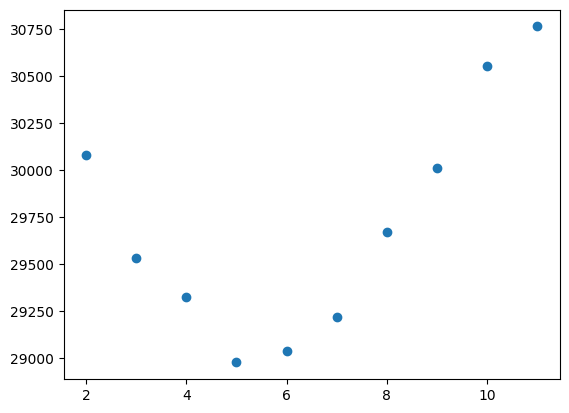

In [33]:
plt.scatter(df_em['n_components'],df_em['bic_score'])
plt.show()

In [34]:
df_em_shroom, df_score_shroom, selected_n_components_shroom = perform_em(x_shroom, y_shroom)

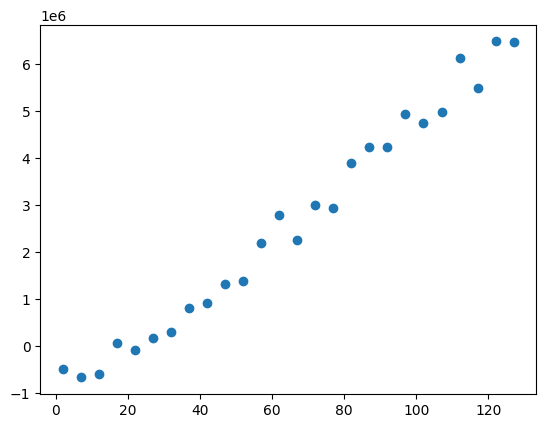

In [43]:
plt.scatter(df_em_shroom['n_components'],df_em_shroom['bic_score'])
plt.show()

In [49]:
df_merge = pd.concat([df_em_shroom, df_score_shroom])
df_merge.head(3)

,n_components,covariance_type,bic_score,std_bic_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,num_clusters,mean_s_score,std_s_score,mean_v_score,std_v_score,mean_ch_score,std_ch_score,mean_ar_score,std_ar_score
1,7,full,-660402.297435,32333.575012,1.393975,0.290404,0.021779,0.001261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,full,-579747.861399,20817.376160,1.979203,0.191882,0.041311,0.011956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2,full,-476165.924424,5447.315859,0.829934,0.314726,0.008132,0.000680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
selected_n_components_shroom

1    7
Name: n_components, dtype: object

In [218]:
df_ica = perform_ica(x_shroom)
df_ica.head()

c:\Users\lboad\py_venv\ml\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\lboad\py_venv\ml\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\lboad\py_venv\ml\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\lboad\py_venv\ml\lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


,num_components,mean_kurtosis,std_kurtosis
0,2,2.261300,1.054309
1,7,3.782135,5.808243
2,12,7.199269,14.774818
3,17,7.580470,16.334070
4,22,7.314984,15.775278


<BarContainer object of 26 artists>

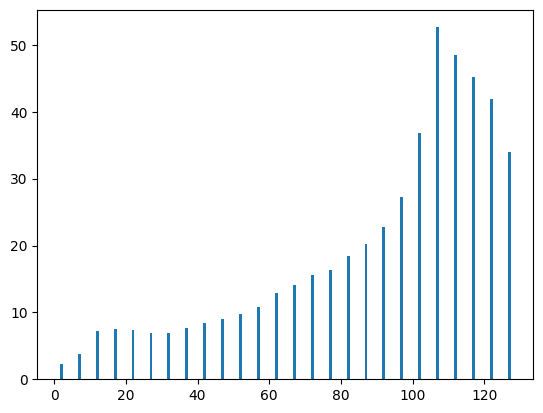

In [219]:
plt.bar(df_ica['num_components'], df_ica['mean_kurtosis'])

In [220]:
df_man = perform_manifold(x_shroom, num_runs=5)
df_man.head(3)

,num_components,mean_recon_error,std_recon_error
0,2,-5.856416e-15,8.819733e-31
1,7,-2.049746e-14,0.000000e+00
2,12,-3.513850e-14,0.000000e+00


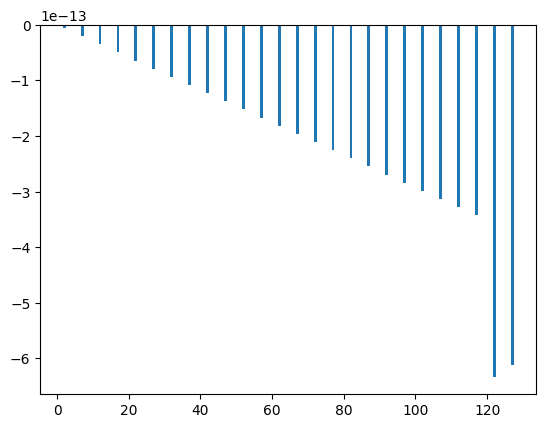

In [221]:
plt.bar(df_man['num_components'],df_man['mean_recon_error'])
plt.show()

In [222]:
mask = df_man['mean_recon_error'].abs() == df_man['mean_recon_error'].abs().min()
df_man[mask]

,num_components,mean_recon_error,std_recon_error
0,2,-5.856416e-15,8.819733e-31


In [17]:
df_km_shroom = perform_kmeans(x_shroom, y_shroom)

In [18]:
df_km_wine = perform_kmeans(x_wine, y_wine)

In [19]:
df_km_shroom.columns

Index(['num_clusters', 'mean_fit_time', 'std_fit_time', 'mean_s_score',
       'std_s_score', 'mean_v_score', 'std_v_score', 'mean_ch_score',
       'std_ch_score', 'mean_ar_score', 'std_ar_score'],
      dtype='object')

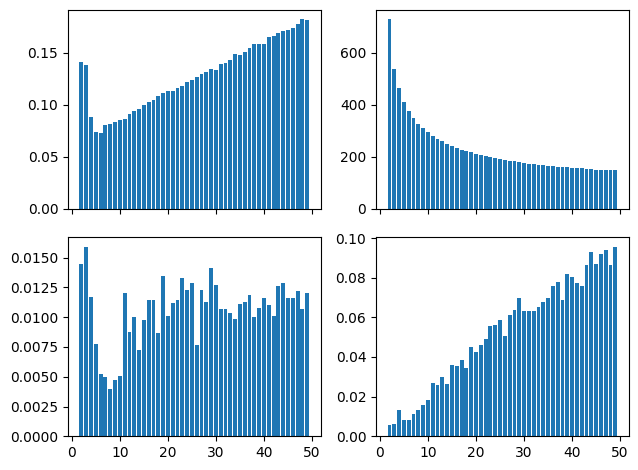

In [20]:
x = df_km_shroom['num_clusters']
fig, axs = plt.subplots(2,2, sharex=True)
axs = axs.flatten()

# Score's do not require ground truth
# The score is bounded between -1 for incorrect clustering
#  and +1 for highly dense clustering.
#  Scores around zero indicate overlapping clusters.
# Sil score -> Higher is Better
axs[0].bar(x,df_km_shroom['mean_s_score'])

# The score is higher when clusters are dense and well separated,
# which relates to a standard concept of a cluster.
# CH SCORE -> Higher is Better
axs[1].bar(x,df_km_shroom['mean_ch_score'])

# Scores require ground truth labels
# The higher the better
axs[2].bar(x,df_km_shroom['mean_ar_score'])

# The higher the better
axs[3].bar(x,df_km_shroom['mean_v_score'])

plt.tight_layout()
plt.show()

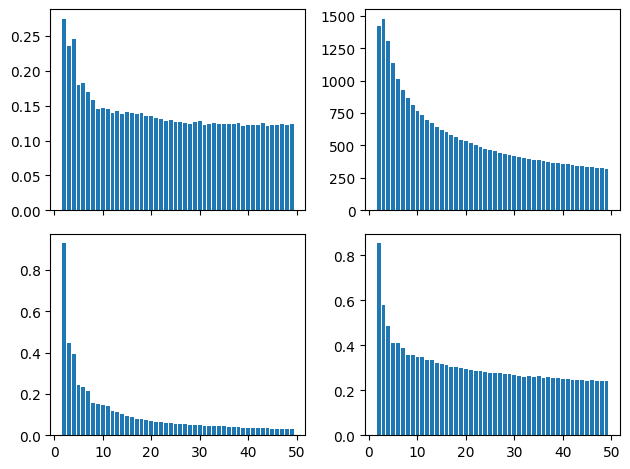

In [21]:
x = df_km_wine['num_clusters']
fig, axs = plt.subplots(2,2, sharex=True)
axs = axs.flatten()

# Score's do not require ground truth
# The score is bounded between -1 for incorrect clustering
#  and +1 for highly dense clustering.
#  Scores around zero indicate overlapping clusters.
# Sil score -> Higher is Better
axs[0].bar(x,df_km_wine['mean_s_score'])

# The score is higher when clusters are dense and well separated,
# which relates to a standard concept of a cluster.
# CH SCORE -> Higher is Better
axs[1].bar(x,df_km_wine['mean_ch_score'])

# Scores require ground truth labels
# The higher the better
axs[2].bar(x,df_km_wine['mean_ar_score'])

# The higher the better
axs[3].bar(x,df_km_wine['mean_v_score'])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

param_grid = {
    "pca__n_components": np.arange(1, (x_shroom.shape[1]+1)),
    "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(x_shroom, y_shroom)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Plot the PCA spectrum
pca.fit(x_shroom)
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig, ax0 = plt.subplots()
ax0.plot(cumsum, "+", linewidth=2)
ax0.set_ylabel("cumulative explained variance ratio")

ax0.axhline(
    0.95,
    linestyle=":",
    label="95% Variance",
)
ax0.axvline(
    60,
    linestyle=":",
    label="n-components",
)
ax0.legend(prop=dict(size=12))
plt.show()

In [ ]:
x_train=x_wine 
num_runs=2

if x_train.shape[1] > 10:
    
    n_components = np.arange(2,x_train.shape[1]+1)
else:
    n_components = np.arange(2,x_train.shape[1]+1, 5)
    
    
average_recon_error_dict = {}

for num in list(range(num_runs)):
    average_recon_error_lst = []

    for n in n_components:
        rca = RCA(n_components=n)
        average_recon_error_lst.\
            append(
                pdist_correllation(
                    rca.inverse_transform(rca.fit_transform(x_train)), x_train
                    )
                )
        
    average_recon_error_dict[f'r_error_{num}'] = average_recon_error_lst

df_recon = pd.DataFrame(average_recon_error_dict)
df_result = pd.DataFrame({
    'num_components': n_components,
    'mean_recon_error': df_recon.mean(1),
    'std_recon_error': df_recon.std(1)
})

In [ ]:
plt.plot(df_result['num_components'],df_result['mean_recon_error'])
plt.show()

In [33]:
x_new, y_new = GaussianMixture(n_init=10, 
                                n_components=5).\
                                    fit(x_wine).sample(n_samples=7000)

x_transformed = pd.DataFrame(x_new)
y_transformed = pd.DataFrame(y_new)

x_final = pd.concat([x_transformed,y_transformed], axis=1)
x_final

,0,1,2,3,4,5,6,7,8,9,10,0
0,1.382651,1.788176,1.145485,-1.172766,0.229921,-0.428147,-0.638661,0.270452,-0.775112,0.015432,0.233603,0
1,0.792601,2.275693,1.969758,-0.055478,2.321600,-1.631464,-1.810912,1.151846,0.973528,2.583443,1.057209,0
2,-0.809475,2.929999,-0.877507,-0.071077,0.041668,-0.029670,0.211062,0.002744,0.887914,-1.616224,0.139107,0
3,2.534949,-1.219848,4.196691,2.453846,2.439697,-1.261063,0.469604,2.827037,-2.229978,3.800301,-1.224791,0
4,-0.140749,0.935291,1.070306,-0.967962,1.822745,-0.585978,0.466922,-0.544604,-0.562939,-0.034310,-1.176047,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.138753,-0.596477,-0.642352,-1.052705,-0.532715,-2.447364,-2.552603,-1.334360,-2.283519,-0.478274,0.196049,4
6996,0.143306,0.069942,-1.338862,-0.777723,0.031409,0.343899,-0.025970,-0.020914,0.054871,0.009079,-0.804767,4
6997,-0.077508,-1.279384,0.822197,-0.832362,-0.292359,-0.549700,-0.040648,-0.671159,0.196058,0.415471,0.553979,4
6998,0.412030,0.642468,-0.966995,-0.777570,-0.560545,-0.626906,-0.040286,-0.487727,0.516734,-0.924656,0.685936,4
